# Compute the Average Attention Weights for Each Layer

In [2]:
import os
import pandas as pd

# ---------------------- Set Up Working Environment ----------------------

# Define working directory and input/output paths
work_dir = os.getcwd()  # Use the current working directory
input_data_dir = os.path.join(work_dir, '../Data')  # Input data directory
output_dir = os.path.join(work_dir, '../Data')      # Output data directory
os.chdir(input_data_dir)  # Change current working directory for file access

# ---------------------- Load Edge-Level Attention Weights ----------------------

# Read the TSV file containing raw attention weights from GAT layers
# Each row represents an edge in a graph with attention values per head per layer
SD10data = pd.read_csv("attention_weights.tsv", sep="\t")

# ---------------------- Compute Mean Attention per Layer ----------------------

# For each layer, compute the mean attention weight across all heads
# Round to 4 decimal places for concise representation

SD10data['attn_layer_1_avg'] = SD10data.filter(regex='^attn_weights_1_head').mean(axis=1).round(4)
SD10data['attn_layer_2_avg'] = SD10data.filter(regex='^attn_weights_2_head').mean(axis=1).round(4)
SD10data['attn_layer_3_avg'] = SD10data.filter(regex='^attn_weights_3_head').mean(axis=1).round(4)
SD10data['attn_layer_4_avg'] = SD10data.filter(regex='^attn_weights_4_head').mean(axis=1).round(4)

# ---------------------- Prepare Output Table ----------------------

# Select relevant columns for export:
# cpm_id - prescription identifier
# Source, Target - edge endpoints
# Layer-wise average attention weights

attention_data = SD10data[[
    'cpm_id', 'Source', 'Target',
    'attn_layer_1_avg',
    'attn_layer_2_avg',
    'attn_layer_3_avg',
    'attn_layer_4_avg'
]]

# ---------------------- Export to TSV ----------------------

# Define output file path
output_file = os.path.join(output_dir, "attention_averages.tsv")

# Export to TSV format for downstream analysis or visualization
attention_data.to_csv(output_file, sep="\t", index=False)

print(f"Average attention weights saved to {output_file}")


Average attention weights saved to D:\博士文件\博士毕业课题材料\维吾尔医药配伍机制量化分析\GraphAI-for-Uyghur-Medicine\Data\../Data\attention_averages.tsv


# Calculate Mutual Attention Between Nodes

In [3]:
import os
import pandas as pd
import numpy as np
from collections import defaultdict
from tqdm import tqdm

# ---------------------- Setup: Define Directory Paths ----------------------

# Define working directory and relative input/output paths
work_dir = os.getcwd()  # Get the current working directory
input_data_dir = os.path.join(work_dir, '../Data')  # Input directory for TSV files
output_dir = os.path.join(work_dir, '../Data')      # Output directory for results

# Set the path for the input attention file
file_path = os.path.join(input_data_dir, "attention_averages.tsv")

# ---------------------- Load Attention Data ----------------------

# Load attention weights averaged over heads for each GAT layer
attention_data = pd.read_csv(file_path, sep='\t')

# Get unique prescription identifiers (cpm_id)
cpm_ids = attention_data['cpm_id'].unique()

# Prepare output file path
output_path = os.path.join(output_dir, "calculated_attention_weights.tsv")

# If output file exists, delete to avoid duplication
if os.path.exists(output_path):
    os.remove(output_path)

# Initialize the output file with a header
with open(output_path, 'w', encoding='utf-8') as f_out:
    f_out.write('cpm_id\tSource\tTarget\tattention\n')

# ---------------------- Attention Aggregation Logic ----------------------

# Define batch size for writing results periodically
batch_size = 100
batch_results = []

# Iterate over each prescription graph (cpm_id) using tqdm for progress tracking
for idx, cpm_id in enumerate(tqdm(cpm_ids, desc="Processing cpm_id")):
    # Filter edges for the current graph
    cpm_data = attention_data[attention_data['cpm_id'] == cpm_id]

    # Get all unique node names and sort for consistency
    nodes = sorted(pd.unique(cpm_data[['Source', 'Target']].values.ravel()))

    # Initialize dictionary to store aggregated attention scores
    attention_dict = defaultdict(float)

    # Multi-layer attention tracing from layer 1 to 4 (deep paths)
    for target in nodes:
        fourth_layer = cpm_data[cpm_data['Target'] == target]

        for _, fourth_row in fourth_layer.iterrows():
            source_4 = fourth_row['Source']
            weight_4 = fourth_row['attn_layer_4_avg']

            third_layer = cpm_data[cpm_data['Target'] == source_4]

            for _, third_row in third_layer.iterrows():
                source_3 = third_row['Source']
                weight_3 = third_row['attn_layer_3_avg']

                second_layer = cpm_data[cpm_data['Target'] == source_3]

                for _, second_row in second_layer.iterrows():
                    source_2 = second_row['Source']
                    weight_2 = second_row['attn_layer_2_avg']

                    first_layer = cpm_data[cpm_data['Target'] == source_2]

                    for _, first_row in first_layer.iterrows():
                        source_1 = first_row['Source']
                        weight_1 = first_row['attn_layer_1_avg']

                        # Compute cumulative attention: product across all 4 layers
                        total_weight = weight_1 * weight_2 * weight_3 * weight_4

                        # Accumulate attention to the final dictionary
                        attention_dict[(source_1, target)] += total_weight

    # Convert accumulated results into a DataFrame
    results = [[cpm_id, src, tgt, weight] for (src, tgt), weight in attention_dict.items()]
    attention_df = pd.DataFrame(results, columns=["cpm_id", "Source", "Target", "attention"])

    # Optional: normalize attention weights per target node
    # attention_df['attention'] = attention_df.groupby('Target')['attention'].transform(lambda x: x / x.sum())

    # Round attention values for compact storage
    attention_df['attention'] = attention_df['attention'].apply(lambda x: round(x, 6))

    # Store results for periodic flushing to file
    batch_results.append(attention_df)

    # Write results every N graphs or at the end
    if (idx + 1) % batch_size == 0 or (idx + 1) == len(cpm_ids):
        combined_df = pd.concat(batch_results, ignore_index=True)
        combined_df.to_csv(output_path, sep='\t', index=False, header=False, mode='a', encoding='utf-8')
        batch_results = []  # Reset batch buffer

# ---------------------- Completion Notice ----------------------

print(f"All cpm_id attention propagation scores have been saved to {output_path}")


Processing cpm_id: 100%|█████████████████████████████████████████████████████████████████| 6/6 [00:04<00:00,  1.48it/s]

All cpm_id attention propagation scores have been saved to D:\博士文件\博士毕业课题材料\维吾尔医药配伍机制量化分析\GraphAI-for-Uyghur-Medicine\Data\../Data\calculated_attention_weights.tsv


# Figure

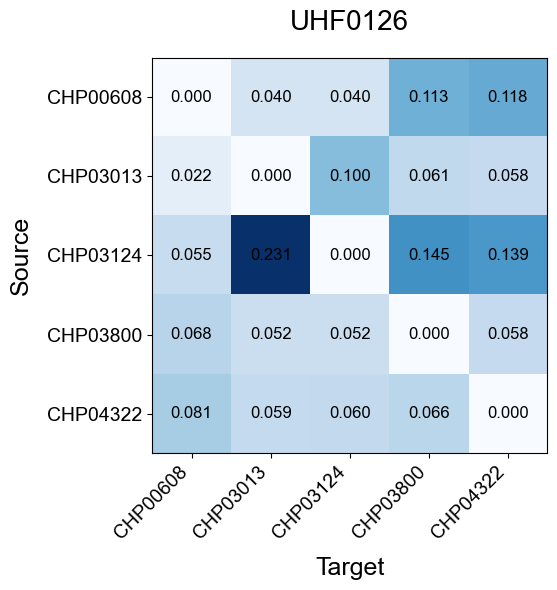

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# ---------------------- Set Up Directory Paths ----------------------

# Define working directory and relative input/output paths
work_dir = os.getcwd()  # Get the current working directory
input_data_dir = os.path.join(work_dir, '../Data')  # Input directory for TSV files
output_dir = os.path.join(work_dir, '../Figure')      # Output directory for results

# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

# ---------------------- Load Required Data ----------------------

# Load metadata for herbal pieces (optional use for annotations)
D6_data = pd.read_csv(os.path.join(input_data_dir, "Uighur_herbal_pieces.tsv"), sep="\t")

# Load precomputed multi-layer attention propagation scores
attention_weights = pd.read_csv(os.path.join(input_data_dir, "calculated_attention_weights.tsv"), sep="\t")

# ---------------------- Filter Graph and Extract Matrix ----------------------

# Retain only edges between valid herbal piece nodes (CHP*) and remove self-loops
attention_filtered = attention_weights[
    attention_weights['Source'].str.startswith("CHP") &
    attention_weights['Target'].str.startswith("CHP") &
    (attention_weights['Source'] != attention_weights['Target'])
]

# Select a specific prescription graph for visualization (by CPM_ID)
cpm_id = "UHF0126"
cpm_id_data = attention_filtered[attention_filtered['cpm_id'] == cpm_id]

# Pivot data into a matrix form suitable for heatmap visualization
heatmap_data = cpm_id_data.pivot(index='Source', columns='Target', values='attention').fillna(0)

# Assign graph label for title or filename use
pinyin_term = cpm_id

# ---------------------- Configure Plot Settings ----------------------

# Set font for axis labels (suitable for English or multilingual text)
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['axes.unicode_minus'] = False  # Fix for minus sign rendering

# Set figure size in inches
pdf_width, pdf_height = 8, 6

# ---------------------- Generate Heatmap Plot ----------------------

fig, ax = plt.subplots(figsize=(pdf_width, pdf_height))
cax = ax.matshow(heatmap_data, cmap="Blues")  # Render attention values as color intensity

# Annotate each cell with its numeric value (rounded to 3 decimal places)
for (i, j), val in np.ndenumerate(heatmap_data.values):
    ax.text(j, i, f"{val:.3f}", ha='center', va='center', color="black", fontsize=12)

# Set axis tick labels (node names)
ax.set_xticks(np.arange(len(heatmap_data.columns)))
ax.set_yticks(np.arange(len(heatmap_data.index)))
ax.set_xticklabels(heatmap_data.columns, rotation=45, ha='right', fontsize=14)
ax.set_yticklabels(heatmap_data.index, fontsize=14)
ax.xaxis.set_ticks_position('bottom')

# Add axis labels and title
plt.xlabel("Target", fontsize=18, labelpad=10)
plt.ylabel("Source", fontsize=18, labelpad=10)
plt.title(f'{pinyin_term}', fontsize=20, pad=20)

# Remove color bar to simplify layout
fig.colorbar(cax, ax=ax).remove()

# Apply tight layout for minimal white space
plt.tight_layout()

# ---------------------- Save and Display Figure ----------------------

# Save figure as a high-resolution PDF file
plt.savefig(
    os.path.join(output_dir, f"{pinyin_term}_Attention_Heatmap.pdf"),
    format='pdf',
    bbox_inches='tight',
    pad_inches=0.1,
    dpi=300
)

# Show plot in notebook or window
plt.show()
